In [6]:
#A Bayesian approach to A/B testing

import pymc as pm

p = pm.Uniform('p', lower=0, upper=1)

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
#setting Constants

p_true = 0.05
N = 3000

#sample N Bernoulli random Variables from Ber(0.05)
#Each random variable has a 0.05 change of being 1.
#This is our data generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences
print occurrences.sum()

[False False False ..., False False False]
127


In [8]:
print "What is the observed frequency in Group A? %.4f" %occurrences.mean()
print "Does this equal the true freq? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0423
Does this equal the true freq? False


In [9]:
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

mcmc = pm.MCMC([p,obs])
mcmc.sample(18000,1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.7 sec

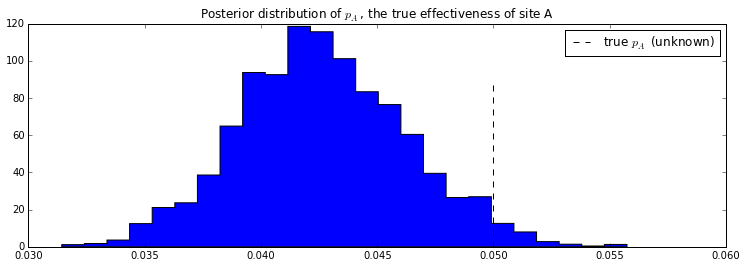

In [10]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle='--', label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [29]:
true_p_A = 0.05
true_p_B = 0.03

N_A = 1500
N_B = 750

#generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)

print "Obs from Site A:", observations_A[:30].astype(int), '...'
print "Obs from Site B:", observations_B[:30].astype(int), '...'



Obs from Site A: [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0] ...
Obs from Site B: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [30]:
print observations_A.mean()
print observations_B.mean()

0.0446666666667
0.0253333333333


In [31]:
#set up pymc model
#Lets continue to assume uniform prior distributions

p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


#Define a deterministic delta function

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

#Let's create some simulated observations, 
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

#Lets generate the simulations

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.8 sec

In [32]:
#Once we have observations we can generate posterior distributions

p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]



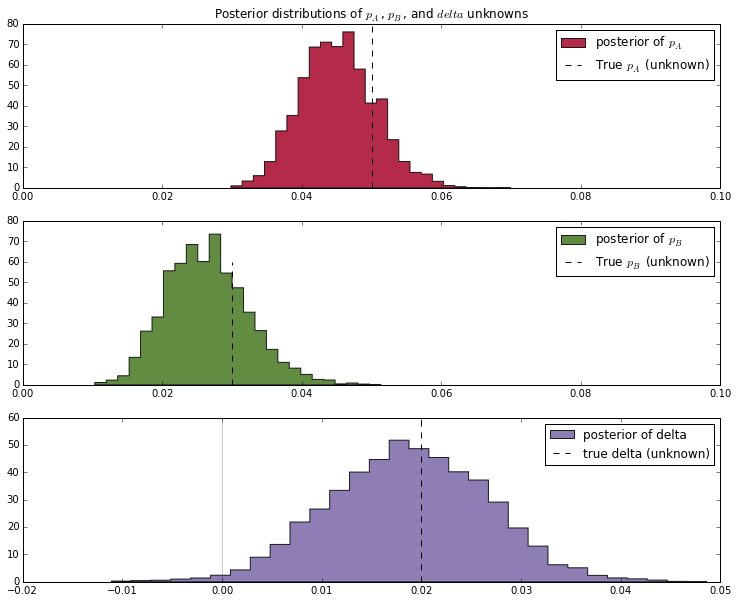

In [33]:
#And now we plot for some visual understanding of the posterior vs prior

figsize(12.5, 10)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype="stepfilled", bins=25, alpha=0.85,
        label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle='--', label="True $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and $delta$ unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype="stepfilled", bins=25, alpha= 0.85,
        label="posterior of $p_B$", color="#467821",normed=True)
plt.vlines(true_p_B, 0, 60, linestyle='--', label="True $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype="stepfilled", bins=30, alpha=0.85,
        label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");




In [34]:
#Since we are comparing two options: Site A and B we can measure th
#difference between the performance in the site
#Since Delta equals A-B we can know that any value of a negative delta
#Suggests that B did better than A
#we can take a mean of the values that are greater than
#and less than zero and get some sense of how likely our results are accurate
print "Probability site A is WORSE than site B: %.3f" % \
        (delta_samples < 0).mean()
    
print "Probability site B is WORSE than site A: %.3f" % \
        (delta_samples > 0).mean()




Probability site A is WORSE than site B: 0.010
Probability site B is WORSE than site A: 0.990


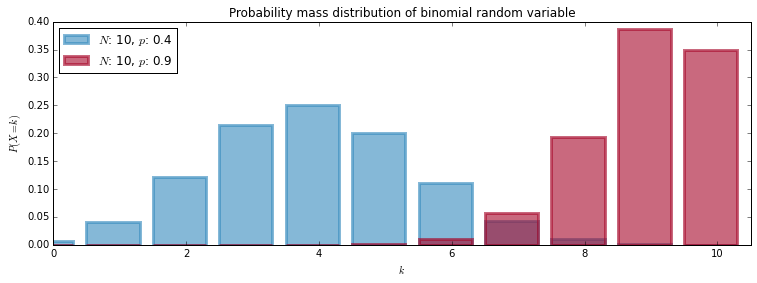

In [39]:
figsize(12.5, 4)
import numpy as np
import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors =["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N+1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i], 
           edgecolor= colors[i],
           alpha=0.6,
           label="$N$: %d, $p$: %.1f" % (N, p),
           linewidth=3)
    
plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X=k)$")
plt.title("Probability mass distribution of binomial random variable");

In [71]:
N = 100
p = pm.Uniform("freq_cheating", 0, 1)

#this is our prior
#We have no idea what the true frequency of cheating is
#We assume it is uniform 
#we generate a discrete set of data with Bernoullian properties of 
#1 and 0
#Of the 100 students we assume that N*p cheated
true_answers = pm.Bernoulli("truths", p, size=N)
#true_answers.value[:30]


In [72]:
#Since we are trying to generate honest responses we introduce a 
#random variable to protect the students' privacy
#We need to generate a data set that represents 
#The outcome of first coin flips
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)

#first_coin_flips.value


In [73]:
#This is the upper boundary of possible second coin flips
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)

In [74]:
#With these variables we will model responses to the question of cheating

@pm.deterministic

def observed_proportion(t_a=true_answers,
                       fc=first_coin_flips,
                       sc=second_coin_flips):
    #Privacy Algo
    #This val = 1 iff it meets the criteria
    observed = fc*t_a + (1 - fc)*sc
    return observed.sum() / float(N)

In [75]:
#this is our posterior probability
observed_proportion.value

0.51000000000000001

In [76]:
#The probability of getting "yes" underrandomness is 1/4
#The way we have set up the problem means that yes will emerge because
#there is 0.5 chance of tails and then the student
#flips again. If on that flip a head comes up the value 
#switches to yes
#thus 0.5*0.5 = .25

#Lets say we have 35 yes or 0.35 
X = 35

observations = pm.Binomial("obs", N, observed_proportion,
                           observed=True, value=X)

In [77]:
model = pm.Model([p, true_answers, first_coin_flips, second_coin_flips, 
                  observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 14.1 sec

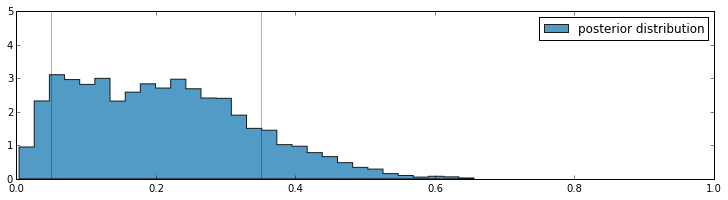

In [78]:
figsize(12.5, 3)

p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace,histtype="stepfilled", normed=True, alpha=0.85,
         bins=30, label="posterior distribution", color="#348ABD")

plt.vlines([.05, .35], [0,0], [5,5], alpha=0.3)
plt.xlim(0,1)
plt.legend();

In [79]:
p = pm.Uniform("freq_cheating", 0, 1)

@pm.deterministic
def p_skewed(p=p):
    return 0.5*p + 0.25

yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, 
                           value = 35, observed = True)

In [80]:
model = pm.Model([yes_responses, p_skewed, p])

mcmc = pm.MCMC(model)
mcmc.sample(25000,2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.8 sec

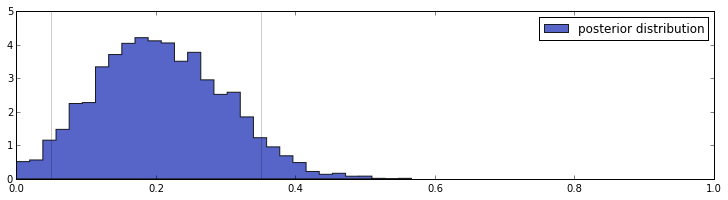

In [81]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85,
        bins=30, label="posterior distribution", color="#384ABD")

plt.vlines([.05, .35], [0,0], [5,5], alpha=0.2)
plt.xlim(0,1)
plt.legend();

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


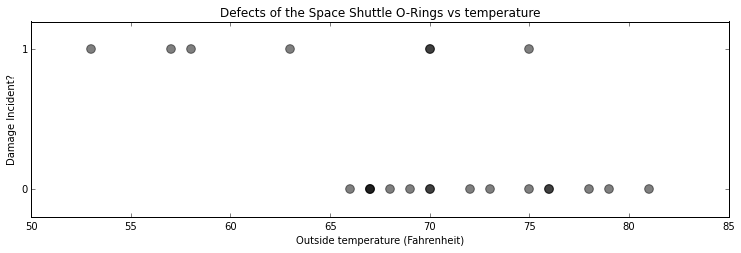

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
figsize(12.5, 4)

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print "Temp (F), O-Ring failure?"
print challenger_data

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

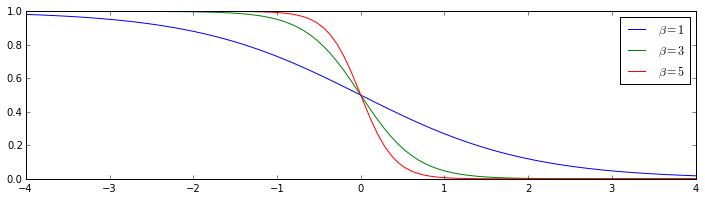

In [5]:
#The purpose of this exercise is to ask
#At Temperature t what is the the probability of incident

#What does a temperature function look like

#This is a logistic function that gives us a probability 
#dependent on the temperature
#p(t) = 1 / (1 + e*(Bt))

figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 +np.exp(beta*x))

x = np.linspace(-4,4,100)
plt.plot(x, logistic(x,1), label=r"$\beta = 1$")
plt.plot(x, logistic(x,3), label=r"$\beta = 3$")
plt.plot(x, logistic(x,5), label=r"$\beta = 5$")
plt.legend();





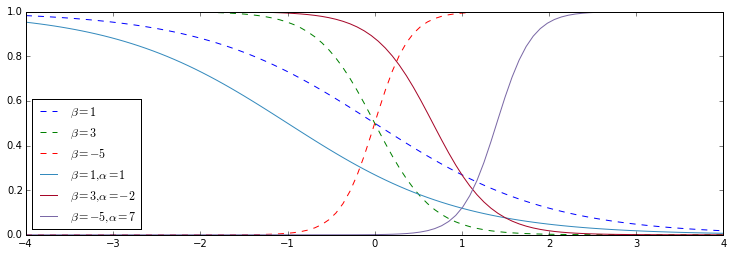

In [11]:
#As we see that our values only change near zero we need to adjust
#for the fact that we know the values only change 
#between 65 and 70 degrees F

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x)+alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");